# TAREA NO. 2 - Estadística Multivariada. Análisis discriminante

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
df = pd.read_csv('discriminante.csv')
df.head()

,Ciudad,Altitud,Año,Mes,Día,T.Max,T.Min,T.media,Dir.Viento,Vel.Viento,Precipitación,Sol,Presión.máx,Presión.min
0,Huelva,19,1990,1,1,15.4,9.4,12.4,300,1.9,9.5,1.8,1020.0,1016.3
1,Huelva,19,1990,1,2,14.6,6.0,10.3,270,2.8,20.8,2.0,1020.9,1011.4
2,Huelva,19,1990,1,3,13.2,8.2,10.7,270,3.1,2.0,4.0,1017.4,1010.0
3,Huelva,19,1990,1,4,15.2,6.2,10.7,10,2.2,0.0,5.4,1024.6,1017.4
4,Huelva,19,1990,1,5,15.2,9.2,12.2,70,1.7,0.0,3.1,1027.3,1024.6


In [3]:
# Eliminar los valores nulos
df = df.dropna()
df.isnull().sum()

Ciudad           0
Altitud          0
Año              0
Mes              0
Día              0
T.Max            0
T.Min            0
T.media          0
Dir.Viento       0
Vel.Viento       0
Precipitación    0
Sol              0
Presión.máx      0
Presión.min      0
dtype: int64

In [4]:
from sklearn.preprocessing import LabelEncoder

y = df['Ciudad']
etiquetas = np.unique(y)
le = LabelEncoder().fit(y)
y = le.transform(y)

In [5]:
X = df.select_dtypes(include='float64').values

In [6]:
X.shape, y.shape

((2553, 8), (2553,))

## 1. Análisis Discriminante

### 1.1. Determinar la Multinormalidad de los datos

Para realizar un análisis discriminante, es importante verificar si los datos son aproximadamente multinormales, ya que este tipo de análisis asume que las variables tienen una distribución normal multivariada. Vamos a realizar una prueba de normalidad multivariada como la prueba de Mardia.

In [7]:
from scipy.stats import shapiro

# Test de Shapiro-Wilk para la normalidad univariante para X_train_val
for i in range(X.shape[1]):
    stat, p = shapiro(X[:, i])
    print(f'Variable {i}: Estadístico={stat}, p={p}', end=' ')
    alpha = 0.05
    if p > alpha:
        print('La muestra parece Gaussiana (no se rechaza H0)')
    else:
        print('La muestra no parece Gaussiana (se rechaza H0)')

Variable 0: Estadístico=0.9824415567353841, p=3.137109499352696e-17 La muestra no parece Gaussiana (se rechaza H0)
Variable 1: Estadístico=0.9886241502940892, p=2.1440662291833924e-13 La muestra no parece Gaussiana (se rechaza H0)
Variable 2: Estadístico=0.97838432361053, p=2.9629652602158975e-19 La muestra no parece Gaussiana (se rechaza H0)
Variable 3: Estadístico=0.958315415148002, p=1.8719265306072852e-26 La muestra no parece Gaussiana (se rechaza H0)
Variable 4: Estadístico=0.34329594887067794, p=4.761299164648623e-70 La muestra no parece Gaussiana (se rechaza H0)
Variable 5: Estadístico=0.9389075169581362, p=3.302377746965693e-31 La muestra no parece Gaussiana (se rechaza H0)
Variable 6: Estadístico=0.9103476639298589, p=2.14930222992852e-36 La muestra no parece Gaussiana (se rechaza H0)
Variable 7: Estadístico=0.9188019654637507, p=5.148729965573072e-35 La muestra no parece Gaussiana (se rechaza H0)


In [8]:
from pingouin import multivariate_normality

# Test de Mardia para la normalidad multivariante
mardia_test = multivariate_normality(X, alpha=0.05)
mardia_test

HZResults(hz=15.014736969291704, pval=0.0, normal=False)

Los resultados de la prueba de Shapiro-Wilk para la normalidad univariante de las variables numéricas indican que el conjunto de datos no sigue una distribución multinormal (requisito de normalidad multivariante). Además, la prueba de multinormalidad muestra que no hay normalidad multivariante, lo cual afecta la posibilidad de aplicar un análisis discriminante lineal (LDA), que asume normalidad en las clases. Sin embargo, aún podemos intentar aplicar Análisis Discriminante Cuadrático (QDA), que es más flexible y no requiere la estricta normalidad.

### 1.2. Análisis Discriminante Cuadrático (QDA)

El uso de la función GridSearchCV permite hacer la validacion cruzada del conjunto de datos de entrenamiento, partiendo los datos en train y validation según el parámetro ‘cv’ que le ingresamos que determina el número de particiones que se van a hacer para finalmente calcular la media de la métrica usada, en este caso accuracy, y extraer el mejor modelo de clasificación.

De esta forma, el dataset esta divido en 3 partes: i) los datos de test que están completamente aislados de los datos de entrenamiento y validación y solo se ace uso de ellos para calcular la precisión en test y la matriz de confusión, ii) los datos restantes que se dividen así mismos en 2 partes que son entrenamiento y validación, pero estas particiones no son fijas ya que en cada una de las iteraciones cambian los valores, lo que permie hacer la validación cruzada.


In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=70, random_state=42)

# Estandarizar los datos
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo
grid = {'reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}
model = QuadraticDiscriminantAnalysis()
model = GridSearchCV(model, grid, cv=5, n_jobs=-1, scoring='accuracy')
model.fit(X_train, y_train)

print('Mejor modelo:', model.best_params_)

Mejor modelo: {'reg_param': 0.1}


In [10]:
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):0.2f}')

Accuracy: 0.90


In [11]:
%timeit model.fit(X_train, y_train)

47.2 ms ± 4.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


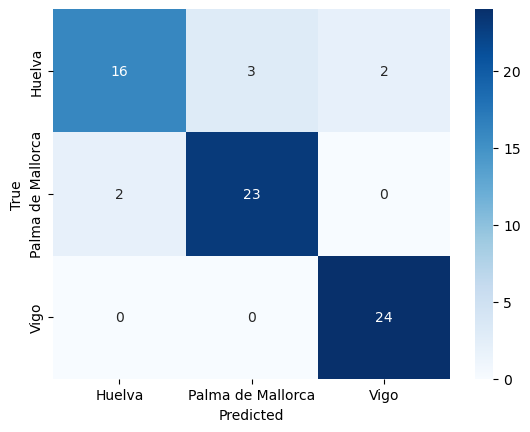

In [12]:
conf_mat = confusion_matrix(y_test, y_pred)

# Graicar la matriz de confusión
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=etiquetas)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=etiquetas)
plt.show()

El modelo de clasificación usando un análisis discriminante cuadrático arroja una precisión mayor al 80%. Para obtener este resultado, se hizo validación cruzada con 5 particiones buscando el mejor parámetro para este conjunto de datos.

La matriz de confusión muestra que la clase que mejor rendimiento obtuvo fue la de Vigo, o sesa, fue la que menos errores de clasificación hay. Sin embargo, las otras dos clases, al tener unos pocos errores más que 'Vigo', afecta notablemente el rendimiento general del modelo de clasificación.

## 2. Clasificación usando KNN

KNN es un algoritmo de aprendizaje supervisado que utiliza la proximidad para clasificar o predecir el grupo al que pertenece un nuevo punto de datos. En términos sencillos, KNN "mira" a los puntos de datos más cercanos (los "k" vecinos más cercanos) a un nuevo punto y asigna a este nuevo punto la clase que es más común entre sus vecinos.

Ventajas:

- Simple de entender e implementar: No requiere de muchos ajustes de parámetros.
- Versátil: Puede utilizarse tanto para clasificación como para regresión.
- No paramétrico: No asume una distribución particular de los datos.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Crear el modelo
grid = {'n_neighbors': [3, 5, 7, 9, 11, 15, 21, 25]}
model = KNeighborsClassifier()
model = GridSearchCV(model, grid, cv=5, n_jobs=-1, scoring='accuracy')
model.fit(X_train, y_train)

print('Mejor modelo:', model.best_params_)

Mejor modelo: {'n_neighbors': 11}


In [14]:
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):0.2f}')

Accuracy: 0.87


In [15]:
%timeit model.fit(X_train, y_train)

152 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


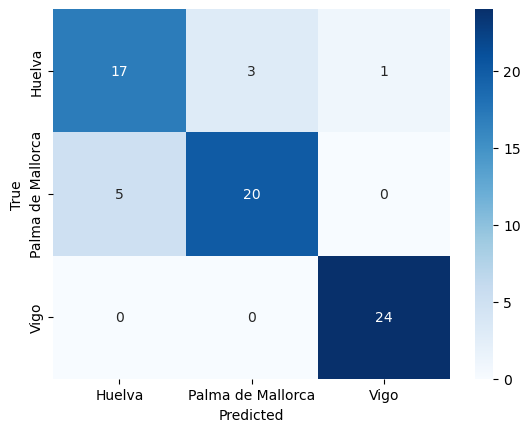

In [16]:
conf_mat = confusion_matrix(y_test, y_pred)

# Graicar la matriz de confusión
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=etiquetas)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=etiquetas)
plt.show()

## 3. Clasificación usando SVM

SVM es un algoritmo de aprendizaje supervisado que busca encontrar el mejor hiperplano que separa dos clases de datos. En términos más simples, SVM trata de encontrar la línea (o hiperplano en dimensiones superiores) que maximiza la distancia entre los puntos de datos de diferentes clases.

Ventajas:

- Alto rendimiento: Suele obtener buenos resultados en muchos problemas de clasificación.
- Robusto a la sobreajustamiento: Gracias a la maximización del margen.
- Versátil: Puede utilizarse para clasificación lineal y no lineal.

In [17]:
from sklearn.svm import SVC

# Crear el modelo
grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
model = SVC()
model = GridSearchCV(model, grid, cv=5, n_jobs=-1, scoring='accuracy')
model.fit(X_train, y_train)

print('Mejor modelo:', model.best_params_)

Mejor modelo: {'C': 10, 'gamma': 0.1}


In [18]:
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):0.2f}')

Accuracy: 0.91


In [19]:
%timeit model.fit(X_train, y_train)

2.5 s ± 54.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


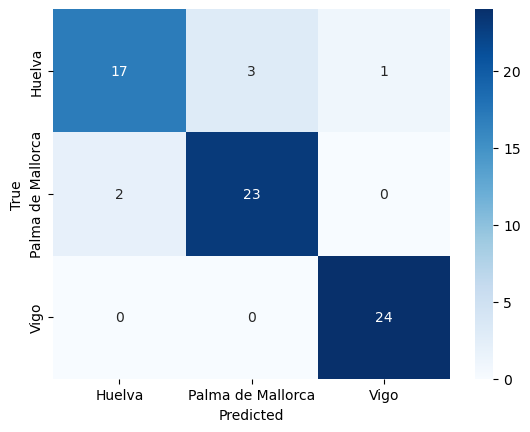

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)

# Graicar la matriz de confusión
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=etiquetas)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=etiquetas)
plt.show()

El rendimiento usando SMV es bastante alto, sin embargo, la complejidad computacional del modelo es algo para evaluar, ya que es un modelo bastante robusto y para encontrar sus mejores parámetros suele ser una tarea bastante compleja computacionalmente, mas cuando se quiere hacer una búsqueda exhaustiva y cuando son muchos datos.

## 4. Conclusiones

#### 4.1. Análisis de los resultados

Según los resultados obtenidos, se podría decir que las condiciones ambientales entre las ciudades de Huelva y Palma de Mallorca son ligeramente similares entre ellas, ya que los tres clasificadores fallaron en algunas observaciones, mientras que la ciudad de Vigo es la que tiene las condiciones más diferenciadas según los tres clasificadores. Sin embargo, esto es en términos generales, ya que el análisis se podría hacer desde el punto de vista de los años y no de las ciudades, o podría hacerse un análisis según los meses del año para identificar en que meses del año las condiciones ambientales son similares en las ciudades.

##### 4.2. Mejor modelo de clasificación
La selección del mejor modelo para el conjunto de datos es un tema complejo ya que depende de muchos factores como la trama de entrenamiento que se use, la cantidad de datos que se usen para entrenamiento o como se parametrizan los modelo. En este caso, se exploró el uso del análisis discriminante cuadrático, k vecinos más cercanos y las maquinas de soporte vectorial, siendo que maquinas de soporte vectorial es la que mejores resultados da, haciendo la respectiva validación cruzada con 5 particiones y encontrando los mejores parámetros en una rejilla definida, ya que este es el mas robusto de los 3 modelos.

Finalmente, los 3 modelos mostrados presentan resultados similares en cuanto a la matriz de confusión, siendo la clase ‘Vigo’ la que mejor porcentaje de clasificación tiene, y las demás son las que bajan el rendimiento general. Una posible solución a este problema seria aumentar el peso de las dos variables que tienen rendimiento bajo con el fin de diseñar un modelo mas general sobre este conjunto de datos.

##### 4.3. Complejidad computacional

En cuanto al tiempo de entrenamiento de cada una de las técnicas, podemos ver que efectivamente SVM es mucho mas lento que los otros dos métodos, esto porque es un modelo basado en resolver un problema de optimización convexa, que puede ser computacionalmente costoso, especialmente para grandes conjuntos de datos. Mientras que KNN calcula las distancias entre el nuevo punto y los k vecinos más cercanos, lo cual es un cálculo relativamente sencillo. Sin embargo, el tiempo de entrenamiento de KNN es peor incluso que el del análisis discriminante cuadrático, ya que KNN debe calcular esas distancias para cada uno de los datos con todos los demás, lo que no es muy eficiente computacionalmente.